### Pooled Calibration Example - Calibration of PTW using Three Ti-6Al-4V SHPB Stress-Strain Curves
In this script, we demonstrate the IMPALA pooled calibration methods using an example from material science. In particular, we consider three Split-Hopkinson pressure bar (SHPB) experiments for Ti-6Al-4V, where the observed data are three stress/strain curves. We calibrate these data on the Preston-Tonks-Wallace (PTW) model, which we treat as a function of 10 unknown inputs. 

#%pip install ../.

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import impala.superCal.post_process as pp
from impala import superCal as sc

Here, we read in the experimental data, where the first column represents plastic strain and the second column represents stress in mbar. 

In [8]:
### Read in Data for Three SHPB Experiments
dat0 = np.array([
    [0.01, 0.0100583],
    [0.02, 0.010381],
    [0.03, 0.0106112],
    [0.04, 0.0108041],
    [0.05, 0.0109619],
    [0.06, 0.011082],
    [0.07, 0.0112103],
    [0.08, 0.0113348],
    [0.09, 0.0114415],
    [0.1, 0.0115094],
])
dat1 = np.array([
    [0.01, 0.004462],
    [0.02, 0.0045834],
    [0.03, 0.0046879],
    [0.04, 0.0047613],
    [0.05, 0.004824],
    [0.06, 0.0048593],
    [0.07, 0.0049031],
    [0.08, 0.0049449],
    [0.09, 0.0049828],
    [0.1, 0.005015],
    [0.11, 0.0050471],
    [0.12, 0.0050752],
    [0.13, 0.0050964],
    [0.14, 0.0051326],
    [0.15, 0.0051495],
    [0.16, 0.0051803],
    [0.17, 0.0051816],
    [0.18, 0.0052018],
    [0.19, 0.0052262],
    [0.2, 0.0052345],
    [0.21, 0.0052651],
    [0.22, 0.0052795],
    [0.23, 0.005296],
    [0.24, 0.0053118],
    [0.25, 0.0053274],
    [0.26, 0.0053431],
    [0.27, 0.00536],
    [0.28, 0.0053702],
    [0.29, 0.0053762],
    [0.3, 0.0053926],
    [0.31, 0.00541],
    [0.32, 0.0054108],
])
dat2 = np.array([
    [0.005682, 0.0075202],
    [0.012309, 0.0077424],
    [0.020317, 0.0078811],
    [0.02867, 0.0079921],
    [0.036673, 0.0080891],
    [0.045022, 0.0081583],
    [0.05337, 0.0082275],
    [0.061718, 0.0082967],
    [0.070064, 0.008352],
    [0.078411, 0.0084074],
    [0.087102, 0.0084349],
    [0.095447, 0.0084763],
    [0.103792, 0.0085177],
    [0.112137, 0.0085591],
    [0.120482, 0.0086005],
    [0.129173, 0.008628],
    [0.137517, 0.0086555],
    [0.145862, 0.0086969],
    [0.154206, 0.0087244],
    [0.162897, 0.0087519],
    [0.173673, 0.0087794],
    [0.187578, 0.0088206],
    [0.198008, 0.0088619],
    [0.209478, 0.0088754],
    [0.217127, 0.008903],
    [0.225816, 0.0089166],
    [0.234158, 0.0089302],
    [0.243543, 0.0089438],
    [0.250844, 0.0089713],
    [0.259188, 0.0089988],
    [0.26753, 0.0090124],
    [0.276219, 0.009026],
    [0.28491, 0.0090535],
    [0.293252, 0.0090671],
    [0.301594, 0.0090807],
    [0.310284, 0.0090943],
    [0.318973, 0.0091079],
    [0.327316, 0.0091216],
    [0.336005, 0.0091352],
    [0.346434, 0.0091626],
])

# and here are the temperatures and strain rates for the three experiments:
temp0 = 573.0  # units: Kelvin
temp1 = 1373.0
temp2 = 973.0

edot0 = 800.0  # units: 1/s
edot1 = 2500.0
edot2 = 2500.0

# put the three experiments together in a list
dat_all = [dat0, dat1, dat2]
temps = [temp0, temp1, temp2]
edots = [edot0, edot1, edot2]
nexp = len(dat_all)  # number of experiments

stress_stacked = np.hstack([np.array(v)[:, 1] for v in dat_all])
strain_hist_list = [np.array(v)[:, 0] for v in dat_all]

Let's visualize the data:

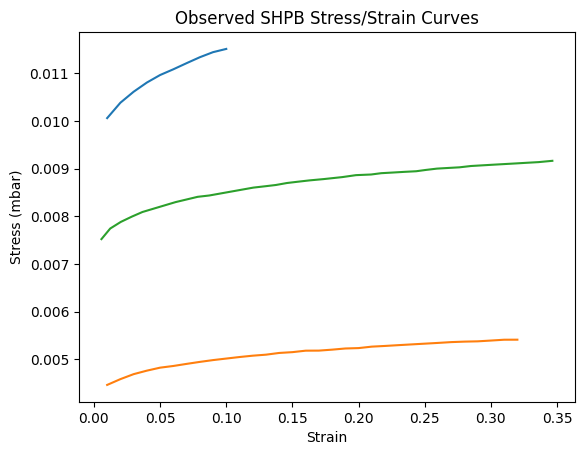

In [7]:
plt.plot(dat0[:, 0], dat0[:, 1])
plt.plot(dat1[:, 0], dat1[:, 1])
plt.plot(dat2[:, 0], dat2[:, 1])
plt.xlabel("Strain")
plt.ylabel("Stress (mbar)")
plt.title("Observed SHPB Stress/Strain Curves")
plt.show()

The Preston-Tonks-Wallace model has several fixed constants we specify for Ti-6Al-4V that are specified below. Additionally, we specify bounds for our 10 PTW input parameters we want to calibrate. PTW constraints on input parameter values are also defined. 

In [9]:
# constants fixed for PTW calibration
consts_ptw = {
    "alpha": 0.2,
    "beta": 0.33,
    "matomic": 45.9,
    "Tmelt0": 2110.0,
    "rho0": 4.419,
    "Cv0": 0.525e-5,
    "G0": 0.4,
    "chi": 1.0,
    "sgB": 6.44e-4,
}

# bounds on PTW input parameters to calibrate
bounds_ptw = {
    "theta": (0.0001, 0.2),
    "p": (0.0001, 5.0),
    "s0": (0.0001, 0.05),
    "sInf": (0.0001, 0.05),
    "kappa": (0.0001, 0.5),
    "lgamma": (-14.0, -9.0),
    "y0": (0.0001, 0.05),
    "yInf": (0.0001, 0.01),
    "y1": (0.001, 0.1),
    "y2": (0.33, 1.0),
}


# constraints: sInf < s0, yInf < y0, y0 < s0, yInf < sInf, s0 < y1, beta < y2 (but beta is fixed)
def constraints_ptw(x, bounds):
    good = (
        (x["sInf"] < x["s0"])
        * (x["yInf"] < x["y0"])
        * (x["y0"] < x["s0"])
        * (x["yInf"] < x["sInf"])
        * (x["s0"] < x["y1"])
    )
    for k in list(bounds.keys()):
        good = good * (x[k] < bounds[k][1]) * (x[k] > bounds[k][0])
    return good

Now, we set up to model structure. IMPALA has many options for the computer model specification, but here we call on IMPALA functions for PTW. The pool=True option indicates that we are running a pooled calibration analysis.

In [10]:
model_ptw = sc.ModelMaterialStrength(
    temps=np.array(temps),
    edots=np.array(edots) * 1e-6,
    consts=consts_ptw,
    strain_histories=strain_hist_list,
    flow_stress_model="PTW_Yield_Stress",
    melt_model="Constant_Melt_Temperature",
    shear_model="Simple_Shear_Modulus",
    specific_heat_model="Constant_Specific_Heat",
    density_model="Constant_Density",
    pool=True,
)

Now we are ready to set up and run our calibration. If several distinct types of experiments (e.g., SHPB and flyer plate experiments) are being used, additional experiments and models can be added to "setup" by calling **setup.addVecExperiments** multiple times.

This code runs a pooled calibration analysis with the following model structure: yobs ~ Normal( PTW(theta) , s2 ), where theta is shared across all experiemnts and PTW(.) indicates a PTW model evaluation.

In [17]:
setup = sc.CalibSetup(bounds_ptw, constraints_ptw)
setup.addVecExperiments(
    yobs=stress_stacked,  # observation vector, here all experiments stacked into a long vector
    model=model_ptw,  # model that predicts a vector. Here, this is our PTW model, but this could be replaced with an emulator.
    sd_est=[
        0.0001
    ],  # yobs error estimate (possibly a vector of estimates for different parts of yobs vector)
    s2_df=[
        15
    ],  # yobs error degrees of freedom (larger means more confidence in sd_est), same shape as sd_est
    s2_ind=[0] * len(stress_stacked),
)  # if sd_est is a vector of length 3, this is a vector of length len(yobs) with values (0, 1, 2) indicating which sd_est corresponds to which part of yobs. Setting
# all values to zero indicates the noise standard error should be the same across experiments
setup.setTemperatureLadder(
    1.05 ** np.arange(50), start_temper=2000
)  # temperature ladder, typically (1 + step)**np.arange(ntemps)
setup.setMCMC(
    nmcmc=10000, nburn=5000, decor=100
)  # MCMC number of iterations, and how often to take a decorrelation step

out = sc.calibPool(setup)  # pooled calibration (takes a couple minutes)

[2024-04-23 11:12:52 | 9999/9999 (100%) | WALL: 0:03:25 | ETA: 0:00:00 | 48.61it/s]
Calibration MCMC Complete. Time: 205.740201 seconds.


We can look at trace plots of the calibration parameters.  We want these to look like they converge, and choose which MCMC iterations to use accordingly. Convergence can sometimes be difficult to assess by eye, but we want these plots to look somewhat like fuzzy caterpillars that are lying totally flat. We will exclude any iterations at the start of the chain that don't exhibit this property. 

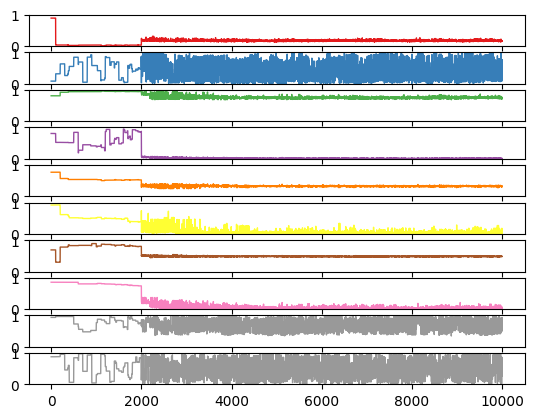

In [18]:
pp.parameter_trace_plot(out.theta[:, 0], ylim=[0, 1])

We disregard the first 5000 iterations and use every other iteration after that, which leaves us with 2500 iterations from our original 10000.  Here is the pairs plot of the calibration parameters' posterior (theta).

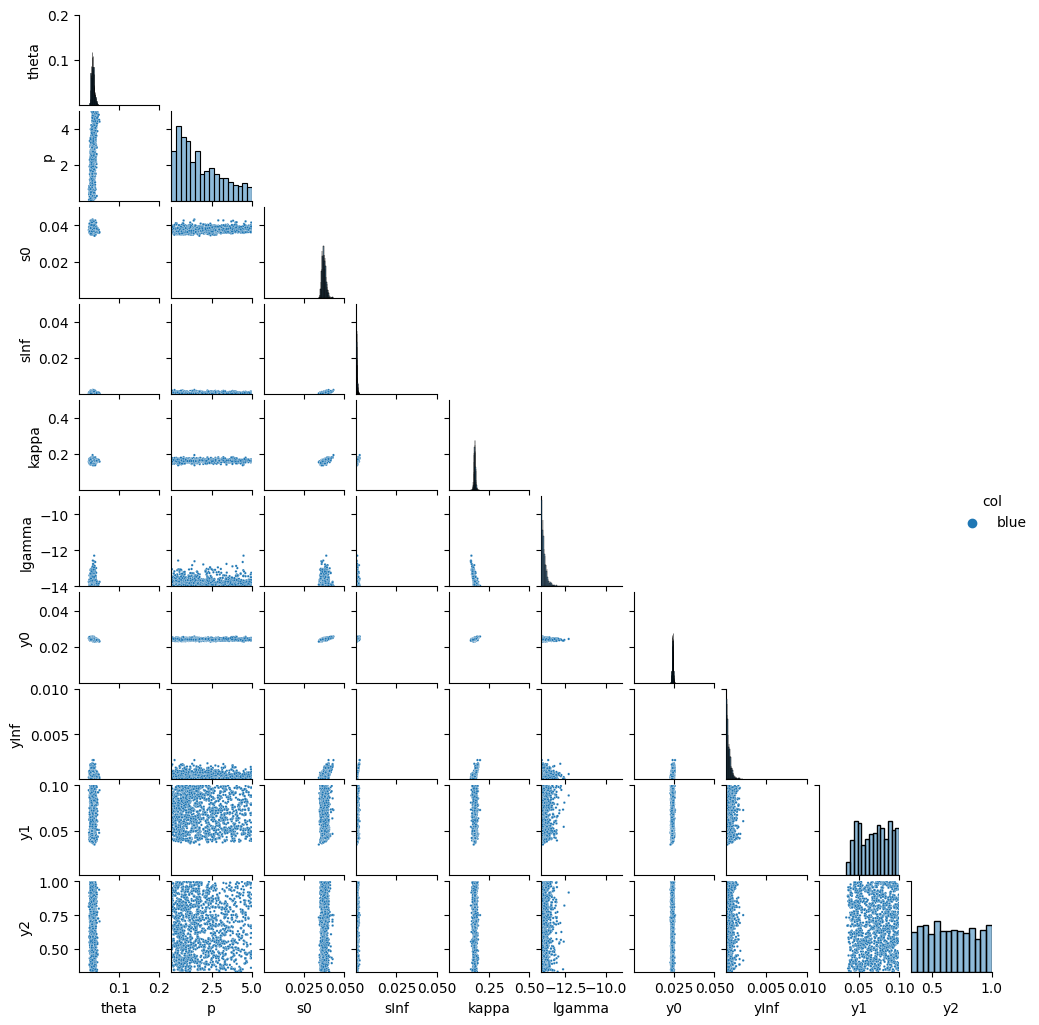

In [21]:
mcmc_use = np.arange(5000, 10000, 2)  # burn and thin index
pp.pairs(setup, out.theta[mcmc_use, 0])

We also give the trace plot of the error variance. Again, we are looking for fuzzy caterpillars. 

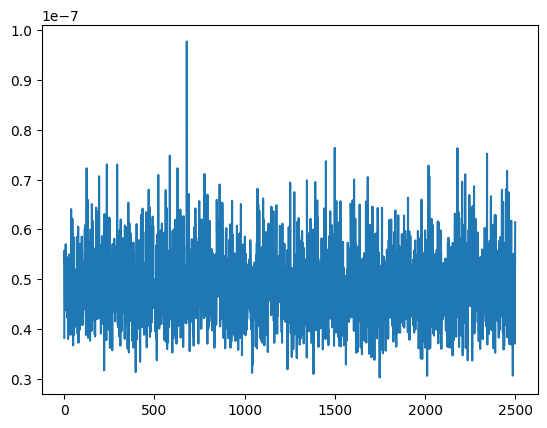

In [22]:
plt.plot(out.s2[0][mcmc_use, 0])

Let's produce our calibrated posterior predictions (with and without the observation error) with the observational data.

Text(0.5, 1.0, 'Observed and Predicted SHPB Stress/Strain Curves')

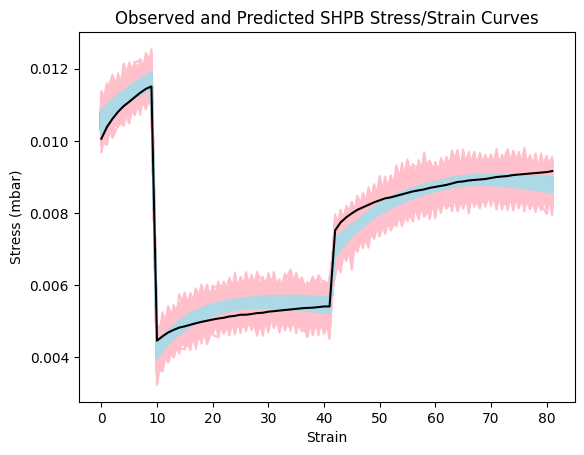

In [50]:
mat = np.array(list(out.theta_native.values())).T[mcmc_use]
pred = setup.models[0].eval(
    dict(
        pd.DataFrame(
            mat, columns=np.array(pd.DataFrame(bounds_ptw.keys())).flatten()
        )
    )
)
pred_s2 = np.random.normal(size=(len(mcmc_use), pred.shape[1])) * np.sqrt(
    out.s2[0][mcmc_use, 0]
)
plt.plot(
    (pred + pred_s2).T, color="pink"
)  # posterior predictions including noise
plt.plot(
    pred.T, color="lightblue"
)  # posterior predictions of noiseless function
plt.plot(stress_stacked, color="black")  # observations
plt.xlabel("Strain")
plt.ylabel("Stress (mbar)")
plt.title("Observed and Predicted SHPB Stress/Strain Curves")

Now, suppose we want to obtain a single set of parameter estimates that best agree with out observed data. Several reasonable approaches exist, but here we identify the posterior draw of theta with the smallest squared prediction error.

In [72]:
pred_sse = np.sum(
    (pred - np.repeat(setup.ys[0].reshape(1, -1), len(mcmc_use), axis=0)) ** 2,
    axis=1,
)
theta_minsse = mat[np.where(pred_sse == pred_sse.min())[0][0], :]

Now, let's add the "best" predictions to the former plot. 

Text(0.5, 1.0, 'Observed and Predicted SHPB Stress/Strain Curves')

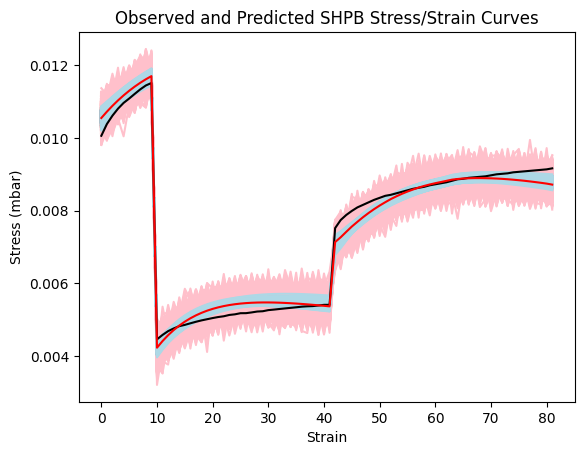

In [76]:
mat = np.array(list(out.theta_native.values())).T[mcmc_use]
pred = setup.models[0].eval(
    dict(
        pd.DataFrame(
            mat, columns=np.array(pd.DataFrame(bounds_ptw.keys())).flatten()
        )
    )
)
pred_s2 = np.random.normal(size=(len(mcmc_use), pred.shape[1])) * np.sqrt(
    out.s2[0][mcmc_use, 0]
)
plt.plot(
    (pred + pred_s2).T, color="pink"
)  # posterior predictions including noise
plt.plot(
    pred.T, color="lightblue"
)  # posterior predictions of noiseless function
plt.plot(stress_stacked, color="black")  # observations
plt.plot(
    pred[np.where(pred_sse == pred_sse.min())[0][0], :], color="red"
)  # observations
plt.xlabel("Strain")
plt.ylabel("Stress (mbar)")
plt.title("Observed and Predicted SHPB Stress/Strain Curves")